In [ ]:
!python --version

In [ ]:
!pip3 install opencv-python==3.4.2.16
!pip3 install opencv-contrib-python==3.4.2.16
!pip3 install scikit-image

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.exposure import match_histograms

#%matplotlib auto

In [2]:
def draw_rectangles(rects,img):
    open_rects = []
    # Create list of rectangles
    for rect in rects:
        x1,x2,x3,x4,y1,y2,y3,y4 = rect
        top_left_x = min([x1,x2,x3,x4])
        top_left_y = min([y1,y2,y3,y4])
        bot_right_x = max([x1,x2,x3,x4])
        bot_right_y = max([y1,y2,y3,y4])
        open_rects.append([top_left_x,top_left_y,bot_right_x,bot_right_y])
    # Use group rectangles
    open_rects = non_max_suppression_fast(open_rects, 0.5)
    # Print only remained rectangles
    for rect in rects:
        for open_rect in open_rects:
            x1,x2,x3,x4,y1,y2,y3,y4 = rect
            top_left_x = min([x1,x2,x3,x4])
            top_left_y = min([y1,y2,y3,y4])
            bot_right_x = max([x1,x2,x3,x4])
            bot_right_y = max([y1,y2,y3,y4])
            if open_rect.tolist() == [top_left_x,top_left_y,bot_right_x,bot_right_y]:
                x1 = max(min(x1,np.shape(img)[1]),4)
                x2 = max(min(x2,np.shape(img)[1]),4)
                x3 = max(min(x3,np.shape(img)[1]),4)
                x4 = max(min(x4,np.shape(img)[1]),4)
                y1 = max(min(y1,np.shape(img)[0]),4)
                y2 = max(min(y2,np.shape(img)[0]),4)
                y3 = max(min(y3,np.shape(img)[0]),4)
                y4 = max(min(y4,np.shape(img)[0]),4)
                cv.line(img, (x1, y1), (x2, y2), (0,255,0), 4)
                cv.line(img, (x2, y2), (x3, y3), (0,255,0), 4)
                cv.line(img, (x3, y3), (x4, y4), (0,255,0), 4)
                cv.line(img, (x4, y4), (x1, y1), (0,255,0), 4)

In [3]:
# Source: (Faster) Non-Maximum Suppression in Python, Malisiewicz et al.
# https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def non_max_suppression_fast(boxes, overlapThresh):
    boxes = np.array(boxes)
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
        np.where(overlap > overlapThresh)[0])))
        
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [4]:
def find_templates(img_scene,img_objects,rect):
    detector = cv.xfeatures2d.SIFT_create()   
    init_keypoints, init_descriptors = detector.detectAndCompute(img_scene, None)
    for img_object in img_objects:
        k = 0
        keypoints_obj, descriptors_obj = detector.detectAndCompute(img_object, None)
        descriptors_scene = np.copy(init_descriptors)
        keypoints_scene = np.copy(init_keypoints)
        old_des_size = len(descriptors_scene)
        u = 0
        while len(descriptors_scene) > 0:
            new_descriptors = []
            new_keypoints = []
            while True:
                # Find good matches with knn and Lowe ratio
                bf = cv.BFMatcher()
                knn_matches = bf.knnMatch(descriptors_obj,descriptors_scene, k=2)
                good_matches = []

                for m,n in knn_matches:
                    if m.distance < 0.90 * n.distance:
                        good_matches.append(m)

                if len(good_matches)<7:
                    break

                # Get points for the homography computation with ransac
                obj = np.empty((len(good_matches),2), dtype=np.float32)
                scene = np.empty((len(good_matches),2), dtype=np.float32)
                for i in range(len(good_matches)):
                    obj[i,0] = keypoints_obj[good_matches[i].queryIdx].pt[0]
                    obj[i,1] = keypoints_obj[good_matches[i].queryIdx].pt[1]
                    scene[i,0] = keypoints_scene[good_matches[i].trainIdx].pt[0]
                    scene[i,1] = keypoints_scene[good_matches[i].trainIdx].pt[1]

                H, M =  cv.findHomography(obj, scene, cv.RANSAC)

                if H is None:
                    break


                # Get object corner in the scene
                obj_corners = np.empty((4,1,2), dtype=np.float32)
                obj_corners[0,0,0] = 0
                obj_corners[0,0,1] = 0
                obj_corners[1,0,0] = img_object.shape[1]
                obj_corners[1,0,1] = 0
                obj_corners[2,0,0] = img_object.shape[1]
                obj_corners[2,0,1] = img_object.shape[0]
                obj_corners[3,0,0] = 0
                obj_corners[3,0,1] = img_object.shape[0]
                scene_corners = cv.perspectiveTransform(obj_corners, H)

                # Save object corner in the scene for later use
                x1 = int(scene_corners[0,0,0])
                x2 = int(scene_corners[1,0,0])
                x3 = int(scene_corners[2,0,0])
                x4 = int(scene_corners[3,0,0])
                y1 = int(scene_corners[0,0,1])
                y2 = int(scene_corners[1,0,1])
                y3 = int(scene_corners[2,0,1])
                y4 = int(scene_corners[3,0,1])

                try:
                    Hinv = np.linalg.inv(H)
                except np.linalg.LinAlgError as err:
                    break

                # Get detected object such that it can be converted with the original one
                crop_img = cv.warpPerspective(img_scene,Hinv,(img_object.shape[1], img_object.shape[0]))

                # Image comparison
                s = ssim(img_object, crop_img)

                #print(np.sum(M))
                M = (M > 0).reshape(-1)
                good_matches = np.array(good_matches)


                # If bigger then given treashold save bounding box
                if s > 0.45:
                    rect.append([x1,x2,x3,x4,y1,y2,y3,y4])
                # Save unused descriptors for next iteration
                else:
                    new_descriptors.extend([descriptors_scene[a.trainIdx] for a in good_matches[M]])
                    new_keypoints.extend([keypoints_scene[a.trainIdx] for a in good_matches[M]])

                remove_indices = [a.trainIdx for a in good_matches[M]]
                descriptors_scene = np.array([i.tolist() for j, i in enumerate(descriptors_scene) if j not in remove_indices], dtype=np.float32)
                keypoints_scene = np.array([i for j, i in enumerate(keypoints_scene) if j not in remove_indices])

            # add non used descriptor back
            descriptors_scene = np.append(descriptors_scene,new_descriptors,0)
            keypoints_scene = np.append(keypoints_scene,new_keypoints,0)
            des_size = len(descriptors_scene)
            u += 1
            # if size changes reset
            if des_size != old_des_size:
                u = 0
            if u > 2:
                break
            old_des_size = len(descriptors_scene)

## First scene

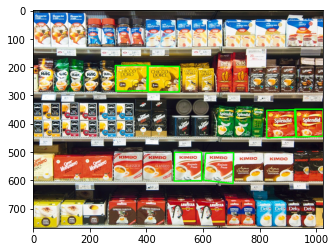

In [5]:
img_objects = []
img_objects.append(cv.imread("images/template1.jpg",cv.IMREAD_GRAYSCALE))
img_objects.append(cv.imread("images/template2.jpg",cv.IMREAD_GRAYSCALE))
img_objects.append(cv.imread("images/template3.jpg",cv.IMREAD_GRAYSCALE))

img_scene = cv.imread("images/scene1.jpg",cv.IMREAD_GRAYSCALE)
rect = []
find_templates(img_scene,img_objects,rect)
img_scene = cv.imread("images/scene1.jpg")
if len(rect)>0:
    draw_rectangles(rect,img_scene)
plt.imshow(cv.cvtColor(img_scene, cv.COLOR_BGR2RGB))

## Similar Templates

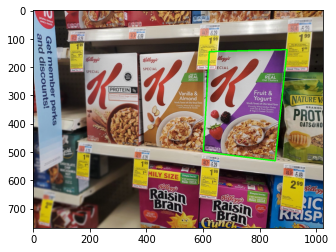

In [6]:
img_objects = []
img_objects.append(cv.imread("images/specialk.jpg",cv.IMREAD_GRAYSCALE))

img_scene = cv.imread("images/cereal.jpg",cv.IMREAD_GRAYSCALE)
rect = []
find_templates(img_scene,img_objects,rect)
img_scene = cv.imread("images/cereal.jpg")
if len(rect)>0:
    draw_rectangles(rect,img_scene)
plt.imshow(cv.cvtColor(img_scene, cv.COLOR_BGR2RGB))

## Second scene

It does not work always... and it is pretty slow

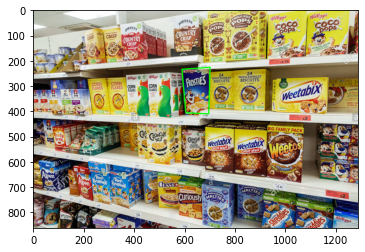

In [8]:
img_objects = []
img_objects.append(cv.imread("images/template4.jpg",cv.IMREAD_GRAYSCALE))
img_objects.append(cv.imread("images/template5.jpg",cv.IMREAD_GRAYSCALE))

img_scene = cv.imread("images/scene2.jpg",cv.IMREAD_GRAYSCALE)
rect = []
find_templates(img_scene,img_objects,rect)
img_scene = cv.imread("images/scene2.jpg")
if len(rect)>0:
    draw_rectangles(rect,img_scene)
plt.imshow(cv.cvtColor(img_scene, cv.COLOR_BGR2RGB))

# Selective Search

In [25]:
detector = cv.xfeatures2d.SIFT_create()   
def find_single_obj(rects,img_scene,img_object):

    keypoints_scene, descriptors_scene = detector.detectAndCompute(img_scene, None)
    keypoints_obj, descriptors_obj = detector.detectAndCompute(img_object, None)
    
    if descriptors_scene is None or descriptors_obj is None:
        return
    # Find good matches with knn and Lowe ratio
    bf = cv.BFMatcher()
    knn_matches = bf.knnMatch(descriptors_obj,descriptors_scene, k=2)
    good_matches = []
    if knn_matches is None or len(knn_matches)<2 or len(knn_matches[0]) < 2:
        return
    for m,n in knn_matches:
        if m.distance < 0.90 * n.distance:
            good_matches.append(m)
    if len(good_matches)==0:
        return


    # Get points for the homography computation with ransac
    obj = np.empty((len(good_matches),2), dtype=np.float32)
    scene = np.empty((len(good_matches),2), dtype=np.float32)
    for i in range(len(good_matches)):
        obj[i,0] = keypoints_obj[good_matches[i].queryIdx].pt[0]
        obj[i,1] = keypoints_obj[good_matches[i].queryIdx].pt[1]
        scene[i,0] = keypoints_scene[good_matches[i].trainIdx].pt[0]
        scene[i,1] = keypoints_scene[good_matches[i].trainIdx].pt[1]

    H, M =  cv.findHomography(obj, scene, cv.RANSAC)

    if H is None:
        return


    # Get object corner in the scene
    obj_corners = np.empty((4,1,2), dtype=np.float32)
    obj_corners[0,0,0] = 0
    obj_corners[0,0,1] = 0
    obj_corners[1,0,0] = img_object.shape[1]
    obj_corners[1,0,1] = 0
    obj_corners[2,0,0] = img_object.shape[1]
    obj_corners[2,0,1] = img_object.shape[0]
    obj_corners[3,0,0] = 0
    obj_corners[3,0,1] = img_object.shape[0]
    scene_corners = cv.perspectiveTransform(obj_corners, H)

    # Save object corner in the scene for later use
    x1 = int(scene_corners[0,0,0])
    x2 = int(scene_corners[1,0,0])
    x3 = int(scene_corners[2,0,0])
    x4 = int(scene_corners[3,0,0])
    y1 = int(scene_corners[0,0,1])
    y2 = int(scene_corners[1,0,1])
    y3 = int(scene_corners[2,0,1])
    y4 = int(scene_corners[3,0,1])

    try:
        Hinv = np.linalg.inv(H)
    except np.linalg.LinAlgError as err:
        return

    # Get detected object such that it can be converted with the original one
    crop_img = cv.warpPerspective(img_scene,Hinv,(img_object.shape[1], img_object.shape[0]))

    # Image comparison
    s = ssim(img_object, crop_img)

    #print(np.sum(M))
    M = (M > 0).reshape(-1)
    good_matches = np.array(good_matches)


    # If bigger then given treashold save bounding box
    if s > 0.45:
        rects.append([x1,x2,x3,x4,y1,y2,y3,y4])


Total Number of Region Proposals: 13533
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


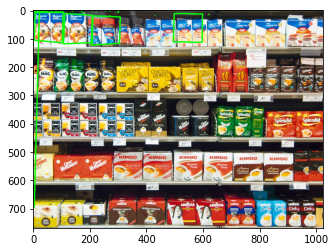

In [28]:
templates = []
# speed-up using multithreads
cv.setUseOptimized(True);
cv.setNumThreads(4);

# read image
im = cv.imread("images/scene1.jpg")
img_object = cv.imread("images/template1.jpg",cv.IMREAD_GRAYSCALE)
# resize image
#newHeight = 200
#newWidth = int(im.shape[1]*200/im.shape[0])
#im = cv.resize(im, (newWidth, newHeight))    

# create Selective Search Segmentation Object using default parameters
ss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

# set input image on which we will run segmentation
ss.setBaseImage(im)

ss.switchToSelectiveSearchFast()

#ss.switchToSelectiveSearchQuality()


# run selective search segmentation on input image
rects = ss.process()
print('Total Number of Region Proposals: {}'.format(len(rects)))
    
# number of region proposals to show
numShowRects = 10000

# itereate over all the region proposals
for i, rect in enumerate(rects):
    if i %100==0:
        print(i)
    # draw rectangle for region proposal till numShowRects
    if (i < numShowRects):
        x, y, w, h = rect
        #cv.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA)
        crop_img = im[y:y+h, x:x+w]
        find_single_obj(templates,cv.cvtColor(crop_img, cv.COLOR_BGR2GRAY),img_object)
    else:
        break
img_scene = cv.imread("images/scene1.jpg")
if len(templates)>0:
    draw_rectangles(templates,img_scene)
plt.imshow(cv.cvtColor(img_scene, cv.COLOR_BGR2RGB))